In [42]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
import matplotlib
import warnings
warnings.filterwarnings('ignore')
import folium
import folium.plugins as plugins
import copy
import os
import subprocess
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from Network import NeuralNetwork
from wordcloud import WordCloud
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from PIL import Image

### Import Data

In [2]:
data = pd.read_csv('sf_data.csv', sep=';')
districts = pd.read_csv('sf_districts.csv', sep=';')
merged_df = pd.merge(data, districts, on='id', how='inner')
data.rename(columns={'time':'timeStr'}, inplace=True)
data.head()

,id,category,description,weekday,date,timeStr,resolution,longitude,latitude,label
0,5069701104134,assault,battery,wednesday,06/22/2005,12:20,none,-122.428223,37.781896,violent
1,6074729204104,assault,assault,saturday,07/15/2006,00:55,none,-122.410672,37.799789,violent
2,7103536315201,assault,stalking,tuesday,09/25/2007,00:01,none,-122.458226,37.741362,violent
3,11082415274000,missing person,missing adult,saturday,09/24/2011,11:00,located,-122.459173,37.708200,other
4,4037801104134,assault,battery,friday,12/12/2003,12:00,none,-122.386667,37.789882,violent


In [3]:
districts.head()

,id,district
0,17074762928150,sunnydale
1,17020189127170,sunnydale
2,18007948463010,sunnydale
3,18001184015200,sunnydale
4,18028426362050,sunnydale


In [4]:
#Create a new column DateTime with a datetime object build from the column "Date" and "Time" - takes ~3 min
#data['DateTime'] = pd.to_datetime(data['date'] + ' ' + data['timeStr'])

#Format the column Date into a datetime object
data['date'] =  pd.to_datetime(data['date'], format='%m/%d/%Y')
merged_df['date'] =  pd.to_datetime(merged_df['date'], format='%m/%d/%Y')

#format the column Time into a datetime.time object
data['Time'] =  pd.to_datetime(data['timeStr'], format='%H:%M').dt.time

# Distributions

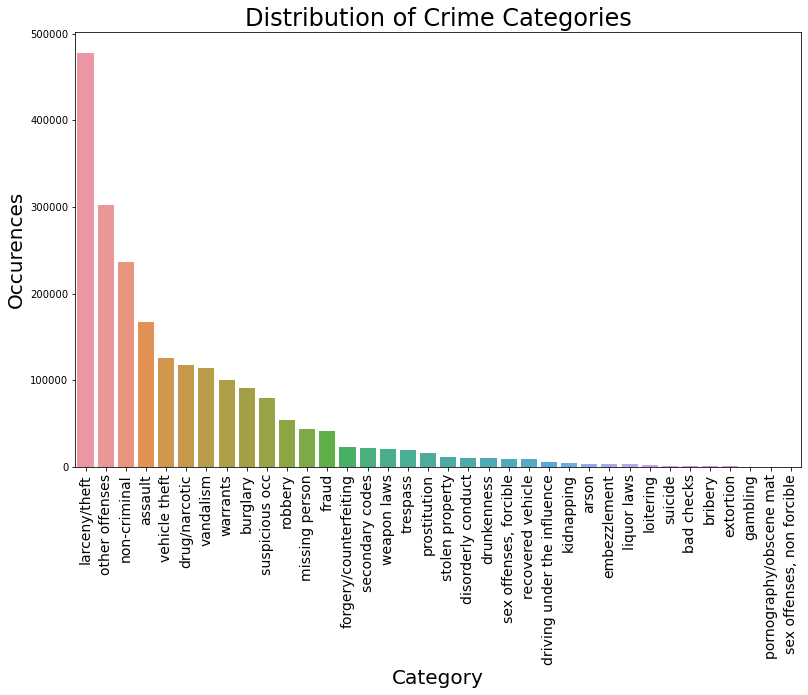

In [148]:
# The most common occuring crime is "larceny/theft" with 477914 occurences and the least occuring crime are
# non-forcible sex offenses

cats = data.groupby("category").count()["id"]
#cats = data.Category.value_counts()
cats = cats.sort_values(ascending=False)

plt.figure(figsize=(13,8))
#cats.plot.bar(width=0.9)
sns.barplot(cats.index, cats.values)
plt.ylabel('Occurences', fontsize=20)
plt.xlabel('Category', fontsize=20)
plt.xticks(fontsize=14, rotation=90)
plt.title('Distribution of Crime Categories', fontsize=24)
#plt.show()
plt.savefig('DistOfCats', bbox_inches='tight', transparent=True)

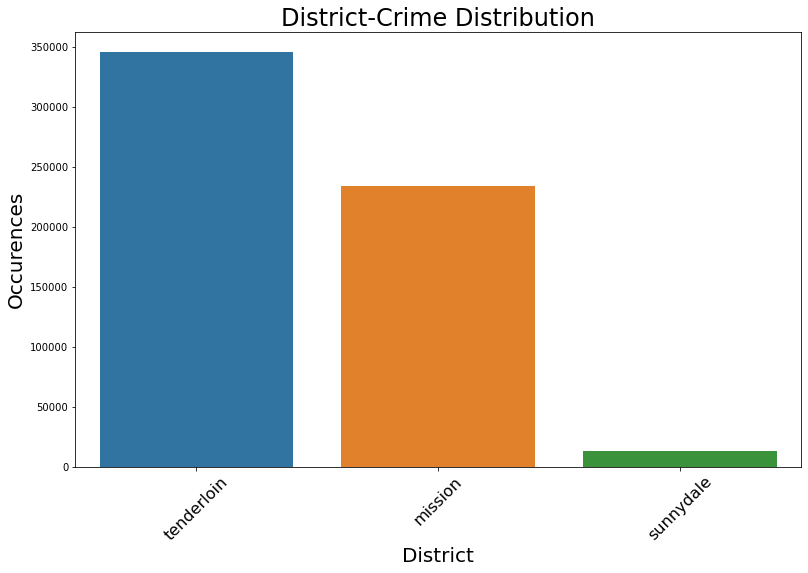

In [6]:
district_counts = merged_df['district'].value_counts()

plt.figure(figsize=(13,8))
plt.title('District-Crime Distribution', fontsize=24)
plt.xlabel('District', fontsize=20)
plt.ylabel('Occurences', fontsize=20)
plt.xticks(rotation=45, fontsize=16)

sns.barplot(district_counts.index, district_counts.values)

plt.show()
#plt.savefig('DistrictCrimeDistribution', bbox_inches='tight', transparent=True)

The average number of crimes per year is : 138944.0


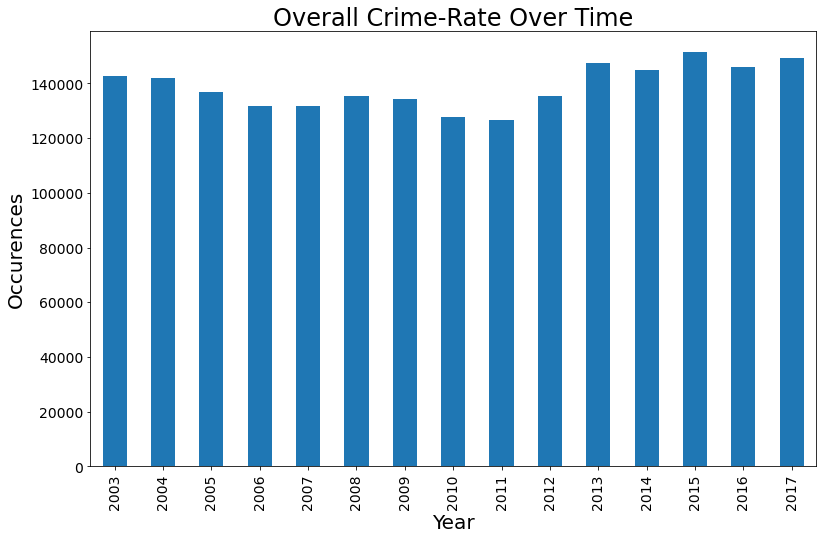

The average number of crimes per year is : 15287.0


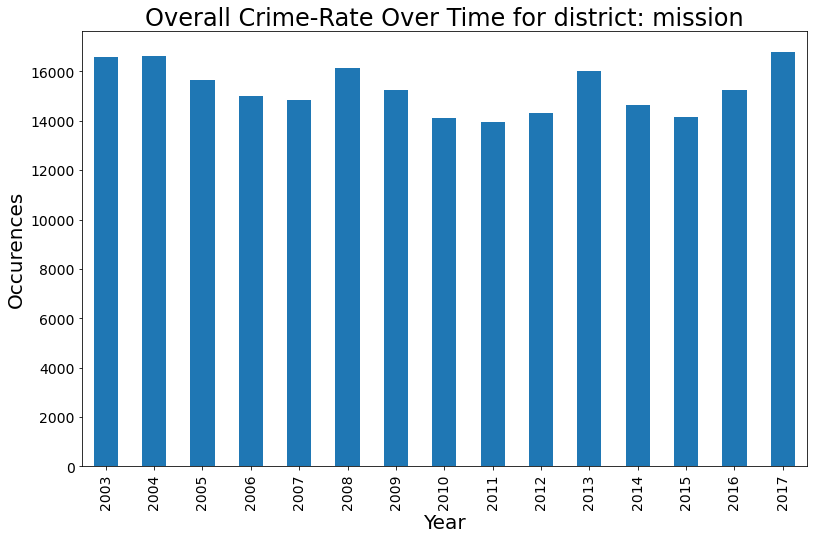

The average number of crimes per year is : 22628.0


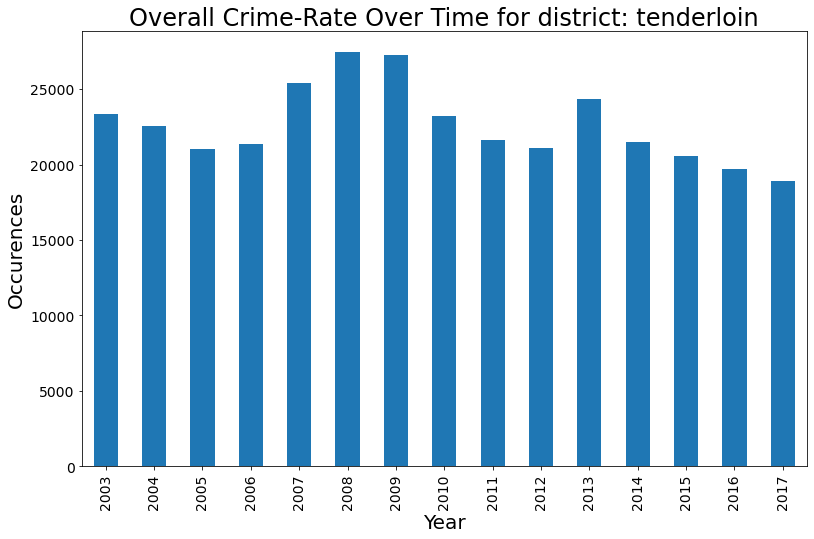

The average number of crimes per year is : 855.0


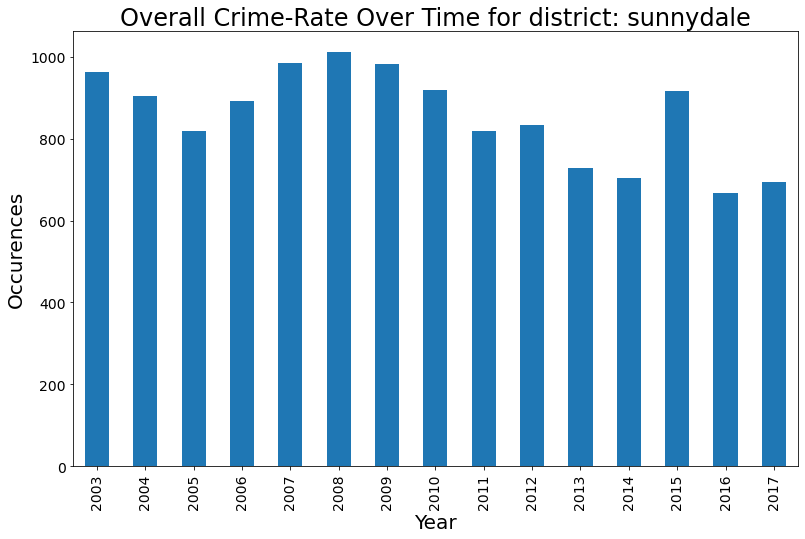

In [7]:
dates = data["date"] # Extracting all dates
years = [dates[i].year for i in range(len(dates))]
data["year"] = years # Inserting year in the dataframe as a new column

year_counts = data.year.value_counts() # List of number of crimes per year
year_counts.sort_index(inplace=True)
year_counts = year_counts[:15] # Removes 2018 since that year is incomplete
avg = np.mean(year_counts)
print("The average number of crimes per year is :", np.round(avg))

plt.figure(figsize=(13,8))
year_counts.plot.bar()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Year', fontsize=20)
plt.ylabel('Occurences', fontsize=20)
plt.title('Overall Crime-Rate Over Time', fontsize=24)
plt.show()
#plt.savefig('OverallCrimeRateOverTime', bbox_inches='tight', transparent=True)


# Per each district
for dist in merged_df['district'].unique():
    dist_df = merged_df[merged_df['district'] == dist]
    dates = dist_df["date"] # Extracting all dates
    years = [dates[i].year for i in dates.index]
    dist_df["year"] = years # Inserting year in the dataframe as a new column

    year_counts = dist_df.year.value_counts() # List of number of crimes per year
    year_counts.sort_index(inplace=True)
    year_counts = year_counts[:15] # Removes 2018 since that year is incomplete
    avg = np.mean(year_counts)
    print("The average number of crimes per year is :", np.round(avg))

    plt.figure(figsize=(13,8))
    year_counts.plot.bar()
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel('Year', fontsize=20)
    plt.ylabel('Occurences', fontsize=20)
    plt.title('Overall Crime-Rate Over Time for district: ' + dist, fontsize=24)
    plt.show()

<BarContainer object of 7 artists>

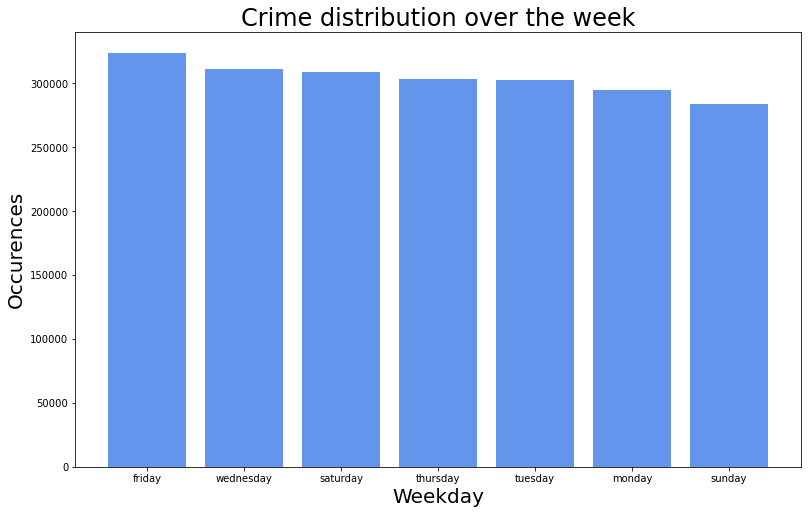

In [8]:
day_count = data['weekday'].value_counts()

plt.figure(figsize=(13,8))
plt.title('Crime distribution over the week', fontsize=24)
plt.xlabel('Weekday', fontsize=20)
plt.ylabel('Occurences', fontsize=20)

plt.bar(day_count.index, day_count.values, color='cornflowerblue')
#plt.show()

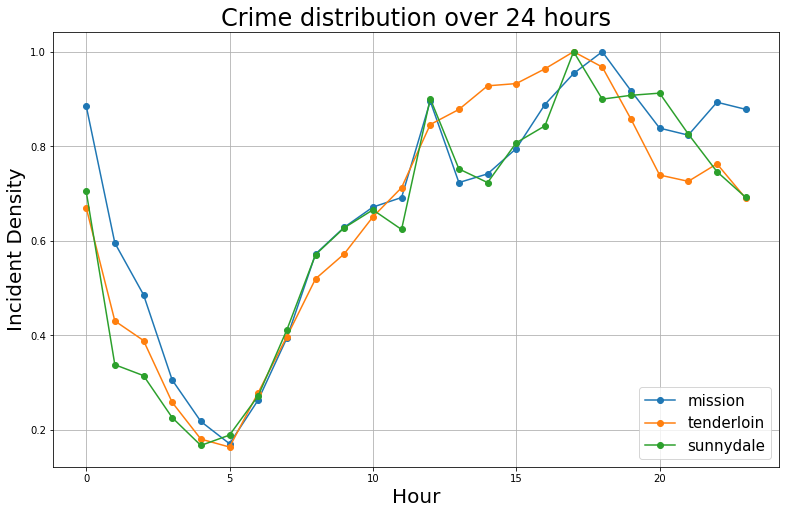

In [141]:
plt.figure(figsize=(13,8))
plt.title('Crime distribution over 24 hours', fontsize=24)
plt.xlabel('Hour', fontsize=20)
plt.ylabel('Incident Density', fontsize=20)

for dist in merged_df['district'].unique():
    
    dist_df = merged_df[merged_df['district'] == dist]
    dist_df['dayhour'] = dist_df.apply(lambda row: row.Time.hour, axis=1)
    hour_count = dist_df['dayhour'].value_counts()
    hour_count /= max(hour_count)
    plt.plot(hour_count.sort_index().index, hour_count.sort_index().values, '-o', label=dist)
    
plt.grid(True)
plt.legend(fontsize=15)
#plt.savefig('PerDistrict24Development', bbox_inches='tight', transparent=True)
plt.show()

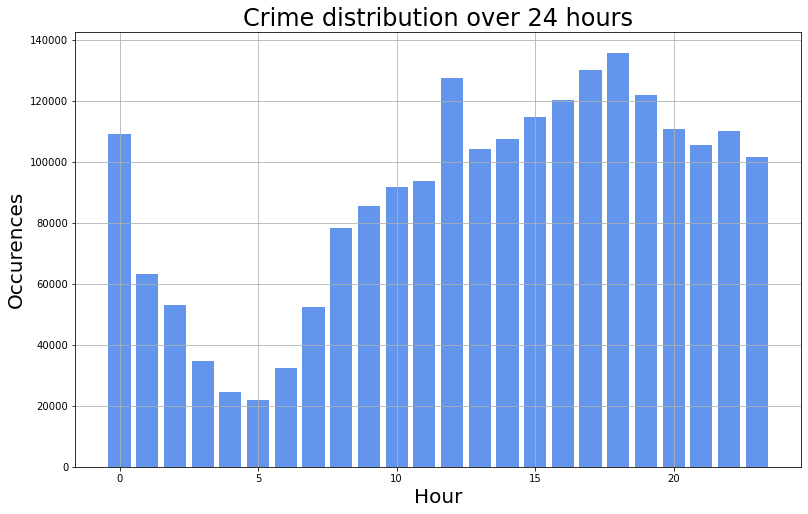

In [140]:
#data['dayhour'] = data.apply(lambda row: row.Time.hour, axis=1)
hour_count = data['dayhour'].value_counts()

plt.figure(figsize=(13,8))
plt.title('Crime distribution over 24 hours', fontsize=24)
plt.xlabel('Hour', fontsize=20)
plt.ylabel('Occurences', fontsize=20)

#plt.plot(hour_count.sort_index().index, hour_count.sort_index().values, '-o', color='cornflowerblue')
plt.grid(True)
plt.bar(hour_count.index, hour_count.values, color='cornflowerblue')
plt.show()
#plt.savefig('CrimeOver24', bbox_inches='tight', transparent=True)

### Box Plot

In [10]:
most_occurring_categories = list(data['category'].value_counts().index[:14]) #list(cats[:14].index)

#create a mask to filter for crimes that are in the list of the focuscrimes
mask = data['category'].isin(most_occurring_categories)

#Create a new dataframe for the relevant data using the mask
data_box = data[mask]

#group data by Date and Category to get daily data for crimes of a certain categories
g = data_box.groupby(['date','category']).id.count()

#using the daily count to measure the average for the whole dataset
p = pd.DataFrame({'count' : data_box.groupby( ['date','category'] ).size()}).reset_index()

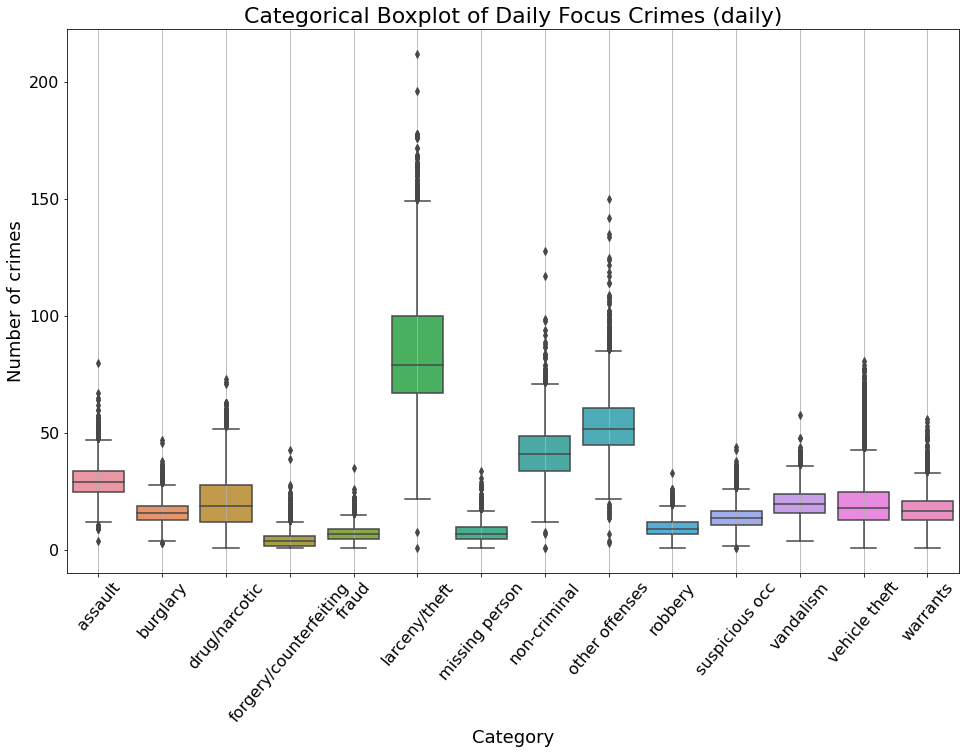

In [143]:
#plot categorical boxplot of the 14 selected crime-types
f, ax = plt.subplots(figsize=(16,10))
sns.boxplot(x="category", y="count", data=p,ax=ax)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=50, fontsize=16)
ax.set_ylabel('Number of crimes', fontsize=18)
plt.yticks(fontsize=16)
plt.xlabel('Category', fontsize=18)
ax.yaxis.grid(False) # Hide the horizontal gridlines
ax.xaxis.grid(True) # Show the vertical gridlines
plt.title('Categorical Boxplot of Daily Focus Crimes (daily)', fontsize=22)
#plt.savefig('BoxPlot', bbox_inches='tight', transparent=True)
plt.show()

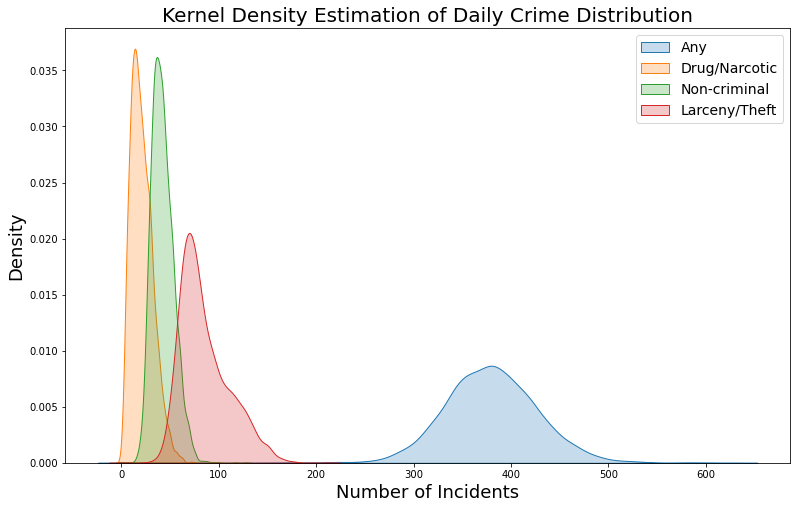

In [12]:
dates_ = data.groupby('date').count().iloc[:, 0]

lt = data[data['category'] == 'larceny/theft']
dn = data[data['category'] == 'drug/narcotic']
bg = data[data['category'] == 'non-criminal']

dates1 = lt.groupby('date').count().iloc[:, 0]
dates2 = dn.groupby('date').count().iloc[:, 0]
dates3 = bg.groupby('date').count().iloc[:, 0]

plt.figure(figsize=(13, 8))
plt.title('Kernel Density Estimation of Daily Crime Distribution', fontsize=20)
sns.kdeplot(data=dates_, shade=True, label='Any')
sns.kdeplot(data=dates2, shade=True, label='Drug/Narcotic')
sns.kdeplot(data=dates3, shade=True, label='Non-criminal')
sns.kdeplot(data=dates1, shade=True, label='Larceny/Theft')
plt.xlabel('Number of Incidents', fontsize=18)
plt.ylabel('Density', fontsize=18)
plt.legend(fontsize=14)
#plt.savefig('KDE', bbox_inches='tight', transparent=True)
plt.show()

## Evolution of crimes per category


In [13]:
categories = data['category'].unique()
most_occurring_categories = list(data['category'].value_counts().index[:14]) #list(cats[:14].index)

In [ ]:
# Plot all categories

plot_all = False

if plot_all:
    df2_2 = data.groupby(['category', data['date'].dt.year]).count()['id'].unstack()
    df2_2.drop(df2_2.columns[-1], 1 , inplace=True)

    for i in range(len(categories)):
        plt.figure(figsize=(13,8))
        df2_2.iloc[i].plot(kind='bar')
        plt.xlabel('Date', fontsize=16)
        plt.title(df2_2.iloc[i].name, fontsize=20)
        plt.show()

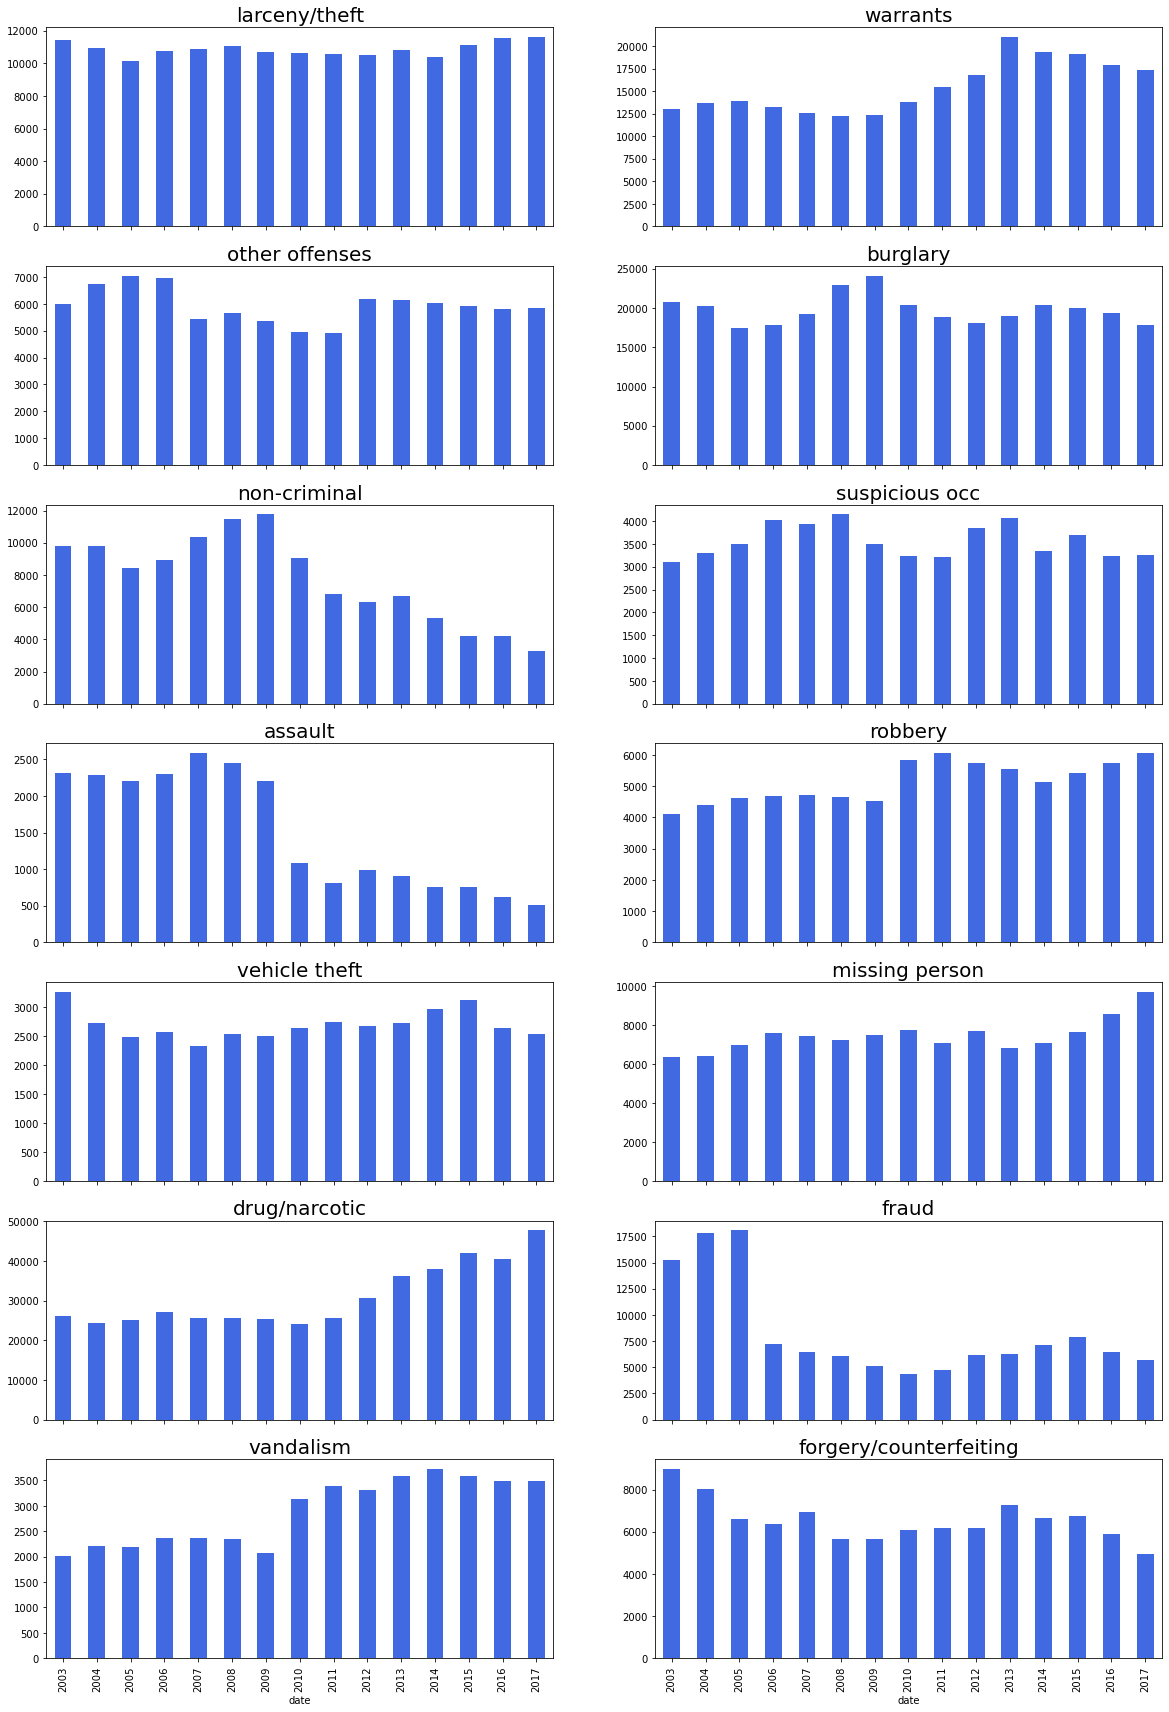

In [14]:
# Extracts all focus crimes from dataset
condition = data.category.isin(most_occurring_categories)
df = data.loc[condition]

# We create a new dataframe which groups all entries by the columns Category and Year and shows the occurences
df2 = df.groupby(["category", data["date"].dt.year]).count()["id"]
df2 = df2.unstack() # Converts from groupby object to dataframe

# We discard the values for 2018 since they are incomplete
df2.drop(df2.columns[-1], 1 , inplace=True)

# Creates a figure of subplots of 7 rows, 2 columns. The x-axis are shared on columns.
fig, ax = plt.subplots(7, 2, sharex = "col", figsize = (20,30))

k = 0
# Plots the data
for i in range(2):
    for j in range(7):
        df2.iloc[k].plot(kind="bar", ax = ax[j, i], color="royalblue")
        ax[j, i].set_title(most_occurring_categories[k], fontsize=20)
        k += 1
        
plt.show()

Temporal Development of the different focus crimes in San Francisco from 2003 - 2017, which gives a nice overview of the on-going trends in crime development.

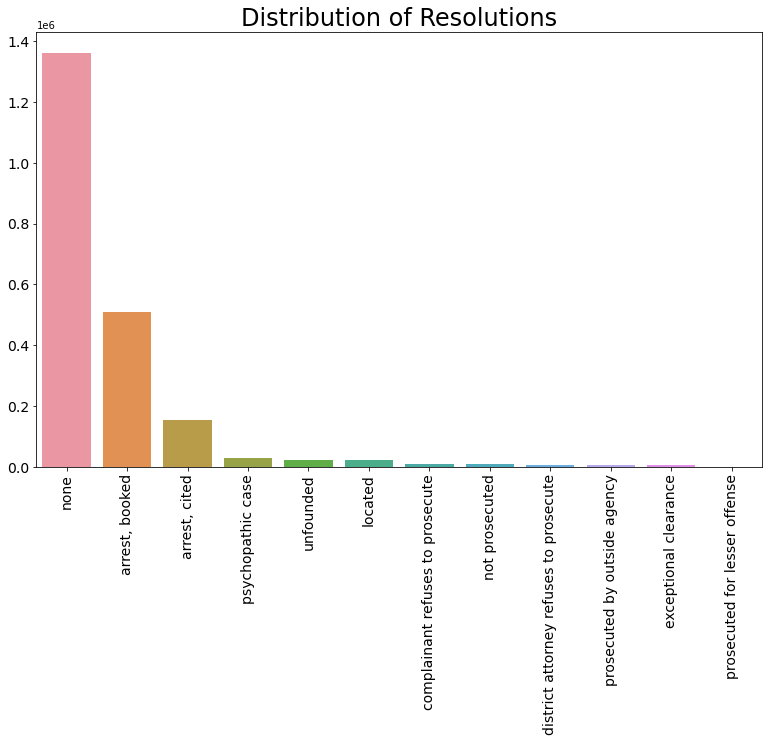

In [237]:
resolutions = data['resolution'].value_counts()
plt.figure(figsize=(13,8))
plt.title('Distribution of Resolutions', fontsize=24)
sns.barplot(resolutions.index, resolutions.values)
plt.xticks(rotation=90, fontsize=14)
plt.yticks(fontsize=14)
#plt.show()
plt.savefig('resolution_distribution', bbox_inches='tight', transparent=True)

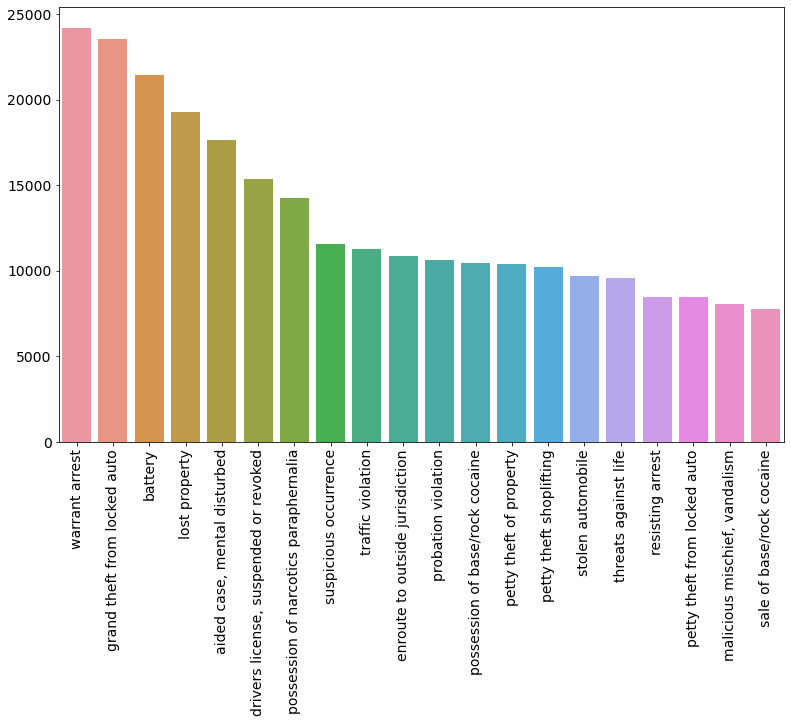

In [236]:
descriptions = merged_df['description'].value_counts()[:20]
plt.figure(figsize=(13,8))
sns.barplot(descriptions.index, descriptions.values)
plt.xticks(rotation=90, fontsize=14)
plt.yticks(fontsize=14)
#plt.show()
plt.savefig('description_distribution', bbox_inches='tight', transparent=True)

## Geodata

I'm selecting two separate, high-volume crime categories, "drug/narcotic" and "larceny/theft", and viewing each of them in a timeframe of a few months (June-July 2016). Thereafter, I am visualizing them geographically, both in terms of scatter plots and heat maps.

In [15]:
#Select data
mask = (data['date'] >= '2016-6-1') & (data['date'] <= '2016-7-31') & (data['category']=='drug/narcotic')      
#mask = (data['category'] == 'drug/narcotic')
data_dn = data[mask]

#take sample of the size of drug/narcotic crimes in the same period (jun-july 2016)
mask = (data['date'] >= '2016-6-1') & (data['date'] <= '2016-7-31') & (data['category']=='larceny/theft') 
#mask = (data['category'] == 'larceny/theft')
data_lt = data[mask].sample(len(data_dn))

In [16]:
#Create map and add circles to drug/narcotic
m_dn = folium.Map([37.77919, -122.41914], zoom_start=13)
# Longitude is X
# Latitude is Y

for index, row in data_dn.iterrows():
    folium.CircleMarker([row['latitude'], row['longitude']],
                        radius=5,
                        #popup=row['category'],
                        fill_color='blue',
                       ).add_to(m_dn)
display(m_dn)

Scatter plot - showing incidents of drugs and narcotics crimes between the dates 01.06.2016 - 31.07.2016

In [17]:
# Create new map and add circles to larceny/theft
m_lt = folium.Map([37.77919, -122.41914], zoom_start=13)

for index, row in data_lt.iterrows():
    folium.CircleMarker([row['latitude'], row['longitude']],
                        radius=5,
                        popup=row['category'],
                       ).add_to(m_lt)
display(m_lt)

Scatter plot - showing a sample of incidents of larceny and theft crimes between the dates 01.06.2016 - 31.07.2016


In [18]:
k = folium.Map([37.77919, -122.41914], zoom_start=13)

# convert to (n, 2) nd-array format for heatmap
stationArr = data_dn[['latitude', 'longitude']].values
# plot heatmap
k.add_children(plugins.HeatMap(stationArr, radius=15))
display(k)

Heatmap - showing incidents of drug/narcotics related crimes between the dates 01.06.2016 - 31.07.2016.


In [19]:
n = folium.Map([37.77919, -122.41914], zoom_start=13)

#create new dataframe with all data for the period jun-july 2016
mask = (data['date'] >= '2016-6-1') & (data['date'] <= '2016-7-31') & (data['category']=='larceny/theft')                                                         
data_lt = data[mask]

# convert to (n, 2) nd-array format for heatmap
stationArr = data_lt[['latitude', 'longitude']].values
# plot heatmap
n.add_children(plugins.HeatMap(stationArr, radius=15))
#for showing the map uncomment the next line - we show a picture due to rerendering problems with folium in notebookk
display(n)

Heatmap - showing incidents of larceny/theft related crimes between the dates 01.06.2016 - 31.07.2016.

### Jitter Plot of robberies in period 1/6-2016 to 31/7-2017

In [ ]:
#Create a mask to filter for a specific time intercal and crime category
mask = (data['date'] > '2016-6-1') & (data['date'] <= '2016-7-31') & (data['category']=='robbery')
data_robbery = data.loc[mask]
#Create index for timeintervall
index = pd.DatetimeIndex(data_robbery['DateTime'])
data_s = data_robbery.iloc[index.indexer_between_time('20:00', '21:00')]
print("Number of selected crimes: {0:d}".format(len(data_s)))

In [ ]:
#Create a jitter plot using the seaborn package
f, ax = plt.subplots(figsize=(15,6))
sns.set(style="whitegrid")
data_s.sort_values(by='Time', inplace=True)
sns.stripplot(x=data_s['timeStr'],jitter=True,ax=ax,dodge=True)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=90)
#change the xticks to even intervals...
ax.legend(['Robbery'])
ax.set_xlabel('Time [hh:mm:ss]')
plt.title('Jitter Plot of the category Robbery')
plt.grid(True)
plt.show()
#plt.grid(True)

## WordClouds of Description

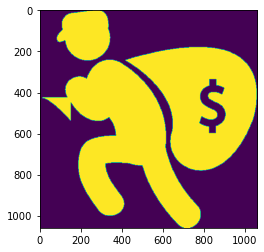

In [121]:
descriptions = merged_df['description']
text =  ' '.join(descriptions)
crime_mask = np.array(Image.open("crime.png"))[:,:,0]
plt.imshow(crime_mask)
transformed_crime_mask = np.ndarray((crime_mask.shape[0], crime_mask.shape[1]), np.int32)

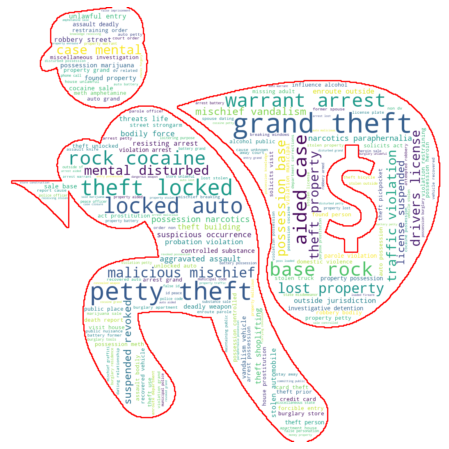

In [123]:
def transform_format(val):
    if val == 0:
        return 255
    else:
        return val

for i in range(len(crime_mask)):
    transformed_crime_mask[i] = list(map(transform_format, crime_mask[i]))
    
wordcloud_mask = WordCloud(background_color='white', width=1200, height=800, contour_width=3, 
                           contour_color='red', mask=transformed_crime_mask).generate(text)

plt.figure(figsize=(13, 8))
plt.imshow(wordcloud_mask, interpolation='bilinear')
plt.axis("off")
#plt.savefig('Wordcloud_Mask', bbox_inches='tight', transparent=True)
plt.show()

## Functionalize

In [245]:
def prep(merged_df, num_classes):

    classes = merged_df['category'].value_counts()[:num_classes+1].index.values
    classes = np.delete(classes, 1)
    print(classes)
    num_classes = len(classes)
    min_sample = merged_df['category'].value_counts()[:num_classes+1].min()
    print(min_sample)
    x_part = []
    for c in classes:
        x_part.append(merged_df[merged_df['category']== c].sample(n=min_sample))

    x = pd.concat(x_part)
    
    df_ml_ = x[['category', 'weekday', 'date', 'Time', 'district', 'resolution', 'description']]
    df_ml_ = df_ml_[df_ml_.category.isin(classes)]
    
    df_ml = df_ml_[df_ml_.columns[:-1]]
    
    #dictionaries to cast crime and districts to integers
    target = {cat:i for (i, cat) in enumerate(classes)}
    dist = {'mission':0, 'tenderloin':1, 'sunnydale':2}
    res = {res:i for (i, res) in enumerate(df_ml['resolution'].value_counts().index)}


    #create new coluns for casted values 
    df_ml['weekday'] = df_ml.apply(lambda row: row.date.weekday(), axis=1)
    df_ml['district_no'] = df_ml.apply(lambda row: dist[row.district], axis=1)
    df_ml['dayhour'] = df_ml.apply(lambda row: row.Time.hour, axis=1)
    df_ml['month'] = df_ml.apply(lambda row: row.date.month, axis=1)
    df_ml['year'] = df_ml.apply(lambda row: row.date.year, axis=1)
    df_ml['resolution_no'] = df_ml.apply(lambda row: res[row.resolution], axis=1)

    df_ml['category_no'] = df_ml.apply(lambda row: target[row.category], axis=1)
    
    X = df_ml[['weekday', 'dayhour', 'month', 'resolution_no']] # 'district_no'
    y = df_ml['category_no']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    
    descriptions = df_ml_['description'].values

    # Build the vocabulary using TFIDF
    tfidf = TfidfVectorizer()
    tfidf.fit(descriptions)
    X_tfidf = tfidf.transform(descriptions).todense()

    # Perform PCA
    pca = PCA(n_components=5)
    Z = pca.fit_transform(X_tfidf)
    Xtrain, Xtest, ytrain, ytest = train_test_split(Z, y, test_size=0.2, random_state=42)
    
    #create and train the decision tree
    dt = DecisionTreeClassifier(min_samples_split=20, random_state=42)
    dt.fit(X_train, y_train)
    yhat = dt.predict(X_test)
    correct_preds = np.equal(y_test, yhat)
    acc_int = (sum(correct_preds) / len(y_test))
    print("Accuracy of the model tested on 20% of the dataset: {0:4.4f}".format(acc_int))
    
    
    #create and train the decision tree
    dt = DecisionTreeClassifier(min_samples_split=20, random_state=42)
    dt.fit(Xtrain, ytrain)
    yhat = dt.predict(Xtest)
    correct_preds = np.equal(ytest, yhat)
    acc_tfidf = (sum(correct_preds) / len(ytest))
    print("Accuracy of the model tested on 20% of the dataset: {0:4.4f}".format(acc_tfidf))
    
    return acc_int, acc_tfidf


In [246]:
merged_df = pd.merge(data, districts, on='id', how='inner')
acc_ints = []
acc_tfidfs = []

nums = np.arange(2,35)

for num in nums:

    acc_int, acc_tfidf = prep(merged_df, num_classes=num)
    acc_ints.append(acc_int)
    acc_tfidfs.append(acc_tfidf)

['larceny/theft' 'drug/narcotic']
71757
Accuracy of the model tested on 20% of the dataset: 0.8811
Accuracy of the model tested on 20% of the dataset: 1.0000
['larceny/theft' 'drug/narcotic' 'non-criminal']
61517
Accuracy of the model tested on 20% of the dataset: 0.6594
Accuracy of the model tested on 20% of the dataset: 1.0000
['larceny/theft' 'drug/narcotic' 'non-criminal' 'assault']
53665
Accuracy of the model tested on 20% of the dataset: 0.4993
Accuracy of the model tested on 20% of the dataset: 0.9999
['larceny/theft' 'drug/narcotic' 'non-criminal' 'assault' 'warrants']
42460
Accuracy of the model tested on 20% of the dataset: 0.4158
Accuracy of the model tested on 20% of the dataset: 1.0000
['larceny/theft' 'drug/narcotic' 'non-criminal' 'assault' 'warrants'
 'vandalism']
21319
Accuracy of the model tested on 20% of the dataset: 0.3498
Accuracy of the model tested on 20% of the dataset: 0.9998
['larceny/theft' 'drug/narcotic' 'non-criminal' 'assault' 'warrants'
 'vandalism' 'su

795
Accuracy of the model tested on 20% of the dataset: 0.1239
Accuracy of the model tested on 20% of the dataset: 0.9856
['larceny/theft' 'drug/narcotic' 'non-criminal' 'assault' 'warrants'
 'vandalism' 'suspicious occ' 'vehicle theft' 'robbery' 'burglary'
 'prostitution' 'fraud' 'missing person' 'weapon laws' 'trespass'
 'secondary codes' 'forgery/counterfeiting' 'disorderly conduct'
 'drunkenness' 'stolen property' 'sex offenses, forcible'
 'recovered vehicle' 'liquor laws' 'kidnapping'
 'driving under the influence' 'loitering' 'embezzlement' 'arson']
725
Accuracy of the model tested on 20% of the dataset: 0.1256
Accuracy of the model tested on 20% of the dataset: 0.9847
['larceny/theft' 'drug/narcotic' 'non-criminal' 'assault' 'warrants'
 'vandalism' 'suspicious occ' 'vehicle theft' 'robbery' 'burglary'
 'prostitution' 'fraud' 'missing person' 'weapon laws' 'trespass'
 'secondary codes' 'forgery/counterfeiting' 'disorderly conduct'
 'drunkenness' 'stolen property' 'sex offenses, f

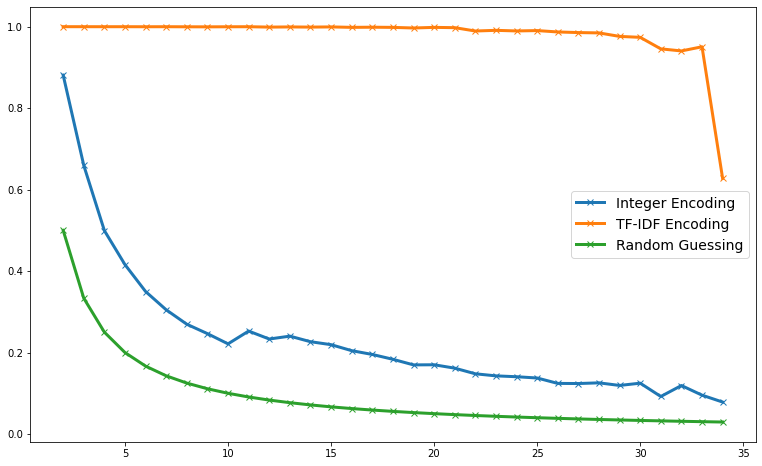

In [262]:
random_guess = 1/nums

num = 33

plt.figure(figsize=(13,8))
plt.plot(nums[:num], acc_ints[:num], '-x', label = 'Integer Encoding', linewidth=3)
plt.plot(nums[:num], acc_tfidfs[:num], '-x', label ='TF-IDF Encoding', linewidth=3)
plt.plot(nums[:num], random_guess[:num], '-x', label ='Random Guessing', linewidth=3)
plt.legend(fontsize=14)
plt.savefig('Accuracies', bbox_inches='tight', transparent=True)

# Crime Prediction

### Prep

In [190]:
merged_df = pd.merge(data, districts, on='id', how='inner')
num_classes = 36
#classes = ['larceny/theft', 'drug/narcotic', 'non-criminal', 'assault', 'warrants']
classes = merged_df['category'].value_counts()[:num_classes+1].index.values
classes = np.delete(classes, 1)
print(classes)
num_classes = len(classes)
min_sample = merged_df['category'].value_counts()[:num_classes+1].min()
print(min_sample)
x_part = []
for c in classes:
    x_part.append(merged_df[merged_df['category']== c].sample(n=min_sample))

#x = pd.concat([x1, x2])
x = pd.concat(x_part)
#classes = merged_df['category'].value_counts()[:num_classes].index.values
x.head()

['larceny/theft' 'drug/narcotic' 'non-criminal' 'assault' 'warrants'
 'vandalism' 'suspicious occ' 'vehicle theft' 'robbery' 'burglary'
 'prostitution' 'fraud' 'missing person' 'weapon laws' 'trespass'
 'secondary codes' 'forgery/counterfeiting' 'disorderly conduct'
 'drunkenness' 'stolen property']
3247


,id,category,description,weekday,date,timeStr,resolution,longitude,latitude,label,Time,year,dayhour,district
232680,8110998606362,larceny/theft,petty theft shoplifting,friday,2008-10-17,10:10,none,-122.408014,37.785951,other,10:10:00,2008,10,tenderloin
437495,8010929606365,larceny/theft,petty theft with prior,thursday,2008-01-31,13:00,"arrest, booked",-122.406428,37.787109,other,13:00:00,2008,13,tenderloin
199407,6045307906362,larceny/theft,petty theft shoplifting,friday,2006-04-28,10:15,"arrest, booked",-122.406352,37.786031,other,10:15:00,2006,10,tenderloin
97678,15054603706243,larceny/theft,petty theft from locked auto,monday,2015-06-22,22:00,none,-122.411116,37.784608,other,22:00:00,2015,22,tenderloin
319180,8013389706361,larceny/theft,petty theft shoplifting,thursday,2008-02-07,17:29,"arrest, cited",-122.415605,37.767718,other,17:29:00,2008,17,mission


In [22]:
df_ml_ = x[['category', 'weekday', 'date', 'Time', 'district', 'resolution', 'description']]
df_ml_ = df_ml_[df_ml_.category.isin(classes)]
df_ml_['category'].value_counts()

non-criminal     42460
larceny/theft    42460
drug/narcotic    42460
warrants         42460
assault          42460
Name: category, dtype: int64

### Integer Encoding

In [23]:
df_ml = df_ml_[df_ml_.columns[:-1]]
df_ml.head()

,category,weekday,date,Time,district,resolution
152373,larceny/theft,friday,2007-06-08,16:30:00,tenderloin,none
366411,larceny/theft,sunday,2009-02-15,13:30:00,tenderloin,none
345308,larceny/theft,sunday,2004-02-08,12:00:00,mission,none
337707,larceny/theft,monday,2008-12-22,21:22:00,tenderloin,none
305913,larceny/theft,wednesday,2008-10-15,15:30:00,tenderloin,none


In [24]:
#dictionaries to cast crime and districts to integers
target = {cat:i for (i, cat) in enumerate(classes)}
dist = {'mission':0, 'tenderloin':1, 'sunnydale':2}
res = {res:i for (i, res) in enumerate(df_ml['resolution'].value_counts().index)}


#create new coluns for casted values 
df_ml['weekday'] = df_ml.apply(lambda row: row.date.weekday(), axis=1)
df_ml['district_no'] = df_ml.apply(lambda row: dist[row.district], axis=1)
df_ml['dayhour'] = df_ml.apply(lambda row: row.Time.hour, axis=1)
df_ml['month'] = df_ml.apply(lambda row: row.date.month, axis=1)
df_ml['year'] = df_ml.apply(lambda row: row.date.year, axis=1)
df_ml['resolution_no'] = df_ml.apply(lambda row: res[row.resolution], axis=1)

df_ml['category_no'] = df_ml.apply(lambda row: target[row.category], axis=1)

In [25]:
X = df_ml[['weekday', 'dayhour', 'month', 'district_no', 'resolution_no']] # 'district_no'
y = df_ml['category_no']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### TF-IDF

In [26]:
descriptions = df_ml_['description'].values

# Build the vocabulary using TFIDF
tfidf = TfidfVectorizer()
tfidf.fit(descriptions)
X_tfidf = tfidf.transform(descriptions).todense()


# Perform PCA
pca = PCA(n_components=5)
Z = pca.fit_transform(X_tfidf)
Xtrain, Xtest, ytrain, ytest = train_test_split(Z, y, test_size=0.2, random_state=42)

## Infer Models

### Integer Encoding

In [27]:
#create and train the decision tree
dt = DecisionTreeClassifier(min_samples_split=20, random_state=42)
#clf = RandomForestClassifier(max_depth=2, random_state=0)
dt.fit(X_train, y_train)
#clf.fit(X_train, y_train)

#use the 20% test data so see how good the decision tree is working with our data
yhat = dt.predict(X_test)
correct_preds = np.equal(y_test, yhat)
acc = (sum(correct_preds) / len(y_test))
print("Accuracy of the model tested on 20% of the dataset: {0:4.4f}".format(acc))

#df_ml['category'].value_counts()

Accuracy of the model tested on 20% of the dataset: 0.4196


In [ ]:
NN = NeuralNetwork([5, 12, num_classes], lr=0.1, afunc='relu')
y_train_onehot = np.eye(num_classes)[y_train]
y_test_onehot = np.eye(num_classes)[y_test]

testcost, traincost = NN.train_loop(X_train.values, y_train_onehot, X_test.values, y_test_onehot, epochs=100, 
                                    batch_size=X_train.shape[0]//10, cost=True)

plt.figure(figsize=(13,8))
plt.plot(testcost, label='Test')
plt.plot(traincost, label='Train')
plt.legend(fontsize=14)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Cross Entropy', fontsize=16)
plt.show()

yhat = NN.feedforward(X_test.values).argmax(axis=1)
#true = y_test_onehot.argmax(axis=1)
#print(true)
correct_preds = np.equal(yhat, y_test)
acc = (sum(correct_preds) / len(y_test))
acc

#### TF-IDF

In [28]:
#create and train the decision tree
dt = DecisionTreeClassifier(min_samples_split=20, random_state=42)
#clf = RandomForestClassifier(max_depth=2, random_state=0)
dt.fit(Xtrain, ytrain)
#clf.fit(Xtrain, ytrain)

#use the 20% test data so see how good the decision tree is working with our data
yhat = dt.predict(Xtest)
correct_preds = np.equal(ytest, yhat)
acc = (sum(correct_preds) / len(ytest))
print("Accuracy of the model tested on 20% of the dataset: {0:4.4f}".format(acc))

Accuracy of the model tested on 20% of the dataset: 0.9999


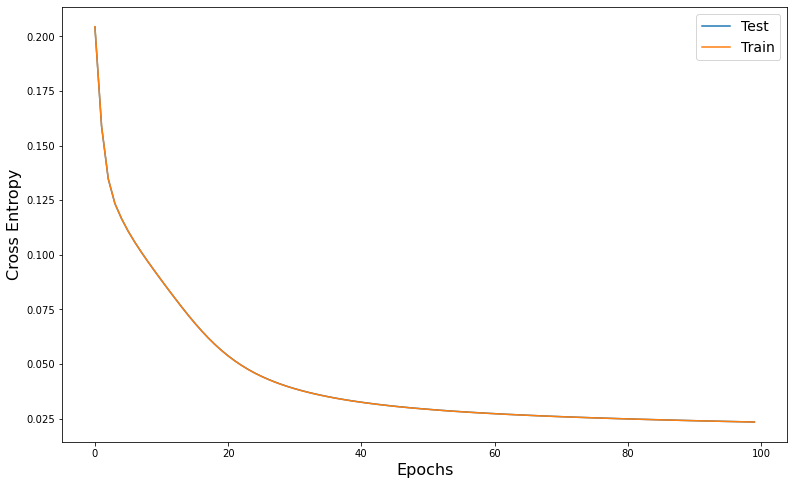

0.9406264719736223

In [265]:
NN = NeuralNetwork([5, 12, num_classes], lr=0.1, afunc='relu')
ytrain_onehot = np.eye(num_classes)[ytrain]
ytest_onehot = np.eye(num_classes)[ytest]


testcost, traincost = NN.train_loop(Xtrain, ytrain_onehot, Xtest, ytest_onehot, epochs=100, 
                                    batch_size=Xtrain.shape[0]//10, cost=True)

plt.figure(figsize=(13,8))
plt.plot(testcost, label='Test')
plt.plot(traincost, label='Train')
plt.legend(fontsize=14)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Cross Entropy', fontsize=16)
plt.show()

yhat = NN.feedforward(Xtest).argmax(axis=1)
#true = y_test_onehot.argmax(axis=1)
#print(true)
correct_preds = np.equal(yhat, ytest)
acc = (sum(correct_preds) / len(ytest))
acc